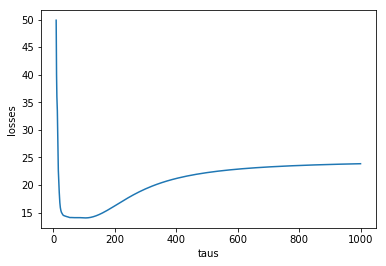

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 12 20:39:09 2017

"""
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston
from scipy.misc import logsumexp
np.random.seed(0)

# load boston housing prices dataset
boston = load_boston()
x = boston['data']
N = x.shape[0]
x = np.concatenate((np.ones((506,1)),x),axis=1) #add constant one feature - no bias needed
d = x.shape[1]
y = boston['target']

idx = np.random.permutation(range(N))




#helper function
def l2(A,B):
    '''
    Input: A is a Nxd matrix
           B is a Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between A[i,:] and B[j,:]
    i.e. dist[i,j] = ||A[i,:]-B[j,:]||^2
    '''
    A_norm = (A**2).sum(axis=1).reshape(A.shape[0],1)
    B_norm = (B**2).sum(axis=1).reshape(1,B.shape[0])
    dist = A_norm+B_norm-2*A.dot(B.transpose())
    return dist
 

def LRLS(test_datum,x_train,y_train, tau,lam=1e-5):
    '''
    Input: test_datum is a dx1 test vector
           x_train is the N_train x d design matrix
           y_train is the N_train x 1 targets vector
           tau is the local reweighting parameter
           lam is the regularization parameter
    output is y_hat the prediction on test_datum
    '''

    
    tau = 2*(tau**2)
    test_datum = test_datum.reshape((1,d))

    placeholder_b = []
    for i in range(x_train.shape[0]):
        b =  -l2(test_datum,x_train[i].reshape((1,14))) / tau
        placeholder_b.append(b[0][0])

    b = logsumexp(placeholder_b)

    
    placeholder_a = []
    for i in range(x_train.shape[0]):
        

        
        a = -l2(test_datum, x_train[i].reshape((1,14))) / tau
        placeholder_a.append(np.exp(a[0][0] - b))
    
    diag = np.diag(placeholder_a)
    
    a = (x_train.T).dot(diag).dot(x_train) 
    b = lam * np.eye(d, dtype=int)
    c = (x_train.T).dot(diag).dot(y_train) 
    w = np.linalg.solve(a+b, c)
    
    return test_datum.dot(w)
    
    



#helper function
def run_on_fold(x_test, y_test, x_train, y_train, taus):
    '''
    Input: x_test is the N_test x d design matrix
           y_test is the N_test x 1 targets vector        
           x_train is the N_train x d design matrix
           y_train is the N_train x 1 targets vector
           taus is a vector of tau values to evaluate
    output: losses a vector of average losses one for each tau value
    '''
    N_test = x_test.shape[0]
    losses = np.zeros(taus.shape)
    for j,tau in enumerate(taus):
        predictions =  np.array([LRLS(x_test[i,:].reshape(d,1),x_train,y_train, tau) \
                        for i in range(N_test)])
        losses[j] = ((predictions.flatten()-y_test.flatten())**2).mean()
    return losses

def run_k_fold(x,y,taus,k):
    '''
    Input: x is the N x d design matrix
           y is the N x 1 targets vector    
           taus is a vector of tau values to evaluate
           K in the number of folds

    '''
    X = []
    Y = []
    X_copy = list(x)
    Y_copy = list(y)
    fold_size = int(len(x) / k)
    for i in range(k):
        X_fold = []
        Y_fold = []
        while len(X_fold) < fold_size:
            # use fixed seed
            index = np.random.choice(len(X_copy), 1)
            
            X_fold.append(X_copy.pop(index[0]))
            Y_fold.append(Y_copy.pop(index[0]))
        X.append(X_fold)
        Y.append(Y_fold)
        
        
    losses = []  
    for i in range(len(X)):
        
        
        x_train = np.array(X[:i]+X[i+1:]).reshape(((k-1)*len(X[0]),d))
        y_train = np.array(Y[:i]+Y[i+1:]).reshape(((k-1)*len(Y[0]),1))


        losses.append(run_on_fold(np.array(X[i]), np.array(Y[i]), x_train, y_train, taus))
        
    return losses



if __name__ == "__main__":
    # change the 3rd parameter to a smaller value if want the program to run faster, say 50
    taus = np.logspace(1.0,3,200)
    
    
    losses = np.array(run_k_fold(x,y,taus,k=5))

    losses_for_taus = losses.sum(axis=0)/5
    

    plt.plot(taus, losses_for_taus)
    plt.xlabel('taus')
    plt.ylabel('losses')
    plt.show()
